In [1]:
import boto3
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import precision_recall_cutoff as prc
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from scipy.stats import boxcox
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.metrics import classification_report
from sklearn.metrics import precision_recall_curve
import precision_recall_cutoff

# Defining the s3 bucket
s3 = boto3.resource('s3')
bucket_name = 'data-445-wagner'
bucket = s3.Bucket(bucket_name)

# Defining the file to be read from s3 bucket
file_key = "turnover.csv"

bucket_object = bucket.Object(file_key)
file_object = bucket_object.get()
file_content_stream = file_object.get('Body')

# Reading the csv file
turnover = pd.read_csv(file_content_stream)
turnover.head()

,satisfaction_level,last_evaluation,number_project,average_montly_hours,time_spend_company,Work_accident,left,promotion_last_5years,sales,salary
0,0.38,0.53,2,157,3,0,1,0,sales,low
1,0.80,0.86,5,262,6,0,1,0,sales,medium
2,0.11,0.88,7,272,4,0,1,0,sales,medium
3,0.72,0.87,5,223,5,0,1,0,sales,low
4,0.37,0.52,2,159,3,0,1,0,sales,low


In [2]:
#Changing to dummy variables
turnover = pd.concat([turnover.drop(columns = ['sales']), pd.get_dummies(turnover['sales'])], axis = 1)
turnover = pd.concat([turnover, pd.get_dummies(turnover['salary'])], axis = 1)

turnover.head()

,satisfaction_level,last_evaluation,number_project,average_montly_hours,time_spend_company,Work_accident,left,promotion_last_5years,salary,IT,...,hr,management,marketing,product_mng,sales,support,technical,high,low,medium
0,0.38,0.53,2,157,3,0,1,0,low,0,...,0,0,0,0,1,0,0,0,1,0
1,0.80,0.86,5,262,6,0,1,0,medium,0,...,0,0,0,0,1,0,0,0,0,1
2,0.11,0.88,7,272,4,0,1,0,medium,0,...,0,0,0,0,1,0,0,0,0,1
3,0.72,0.87,5,223,5,0,1,0,low,0,...,0,0,0,0,1,0,0,0,1,0
4,0.37,0.52,2,159,3,0,1,0,low,0,...,0,0,0,0,1,0,0,0,1,0


In [3]:
#Creating features
turnover['Interaction_1'] = np.where((turnover['satisfaction_level'] <= 0.465) & (turnover['number_project'] <= 2.5) & (turnover['last_evaluation'] <= 0.575), 1, 0)
turnover['Interaction_2'] = np.where((turnover['satisfaction_level'] <= 0.465) & (turnover['number_project'] >= 2.5) & (turnover['satisfaction_level'] <= 0.115), 1, 0)
turnover['Interaction_3'] = np.where((turnover['satisfaction_level'] >= 0.465) & (turnover['time_spend_company'] <= 4.5) & (turnover['average_montly_hours'] <= 290.5), 1, 0)

In [4]:
## Defining the input and target variables
X = turnover.drop(columns = ['left', 'salary'])
Y = turnover['left']

## Splitting the data
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size = 0.2, stratify = Y)

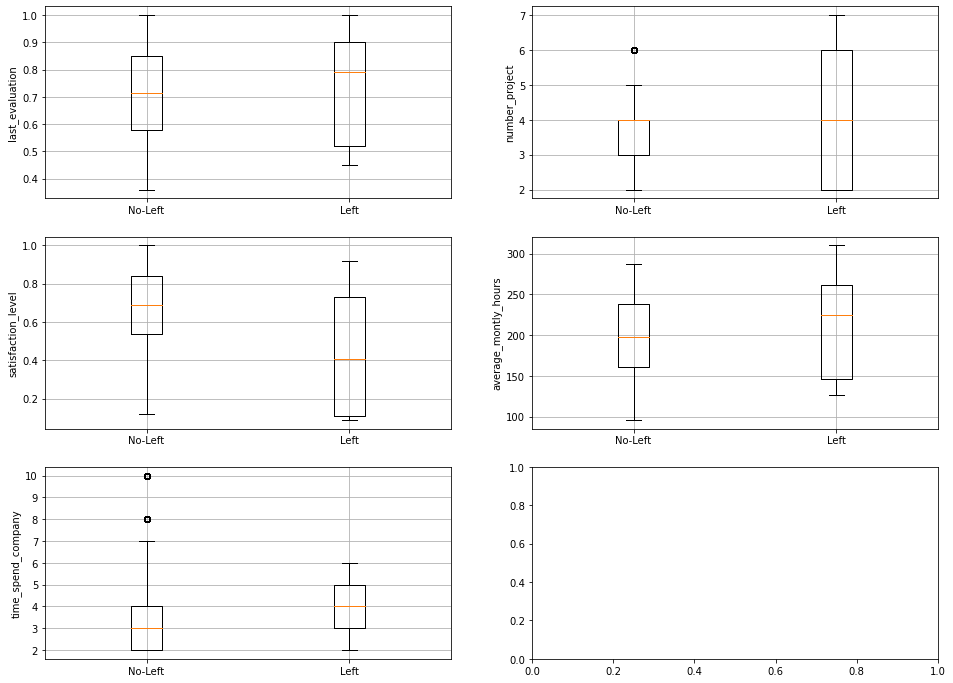

In [6]:
turnover_train = pd.concat([X_train, Y_train], axis = 1)

#Subsetting the data 
fig, axes = plt.subplots(3, 2, figsize = (16, 12))

## Subsetting the data
left = turnover_train[turnover_train['left'] == 1]
no_left = turnover_train[turnover_train['left'] == 0]

axes[0, 0].boxplot([no_left['last_evaluation'], left['last_evaluation']], labels = ['No-Left', 'Left'])
axes[0, 0].set_ylabel('last_evaluation')
axes[0, 0].grid()

axes[0, 1].boxplot([no_left['number_project'], left['number_project']], labels = ['No-Left', 'Left'])
axes[0, 1].set_ylabel('number_project')
axes[0, 1].grid()

axes[1, 0].boxplot([no_left['satisfaction_level'], left['satisfaction_level']], labels = ['No-Left', 'Left'])
axes[1, 0].set_ylabel('satisfaction_level')
axes[1, 0].grid()

axes[1, 1].boxplot([no_left['average_montly_hours'], left['average_montly_hours']], labels = ['No-Left', 'Left'])
axes[1, 1].set_ylabel('average_montly_hours')
axes[1, 1].grid()

axes[2, 0].boxplot([no_left['time_spend_company'], left['time_spend_company']], labels = ['No-Left', 'Left'])
axes[2, 0].set_ylabel('time_spend_company')
axes[2, 0].grid()

In [7]:
pd.crosstab(turnover_train['Work_accident'], turnover_train['left'], normalize = 'index')

left,0,1
Work_accident,,
0,0.733957,0.266043
1,0.926074,0.073926


In [8]:
pd.crosstab(turnover_train['promotion_last_5years'], turnover_train['left'], normalize = 'index')

left,0,1
promotion_last_5years,,
0,0.757957,0.242043
1,0.947791,0.052209


In [9]:
pd.crosstab(turnover_train['IT'], turnover_train['left'], normalize = 'index')

left,0,1
IT,,
0,0.760192,0.239808
1,0.781478,0.218522


In [10]:
pd.crosstab(turnover_train['RandD'], turnover_train['left'], normalize = 'index')

left,0,1
RandD,,
0,0.757157,0.242843
1,0.845201,0.154799


In [11]:
pd.crosstab(turnover_train['accounting'], turnover_train['left'], normalize = 'index')

left,0,1
accounting,,
0,0.763684,0.236316
1,0.727880,0.272120


In [12]:
pd.crosstab(turnover_train['hr'], turnover_train['left'], normalize = 'index')

left,0,1
hr,,
0,0.764557,0.235443
1,0.709343,0.290657


In [14]:
pd.crosstab(turnover_train['management'], turnover_train['left'], normalize = 'index')

left,0,1
management,,
0,0.757789,0.242211
1,0.854617,0.145383


In [15]:
pd.crosstab(turnover_train['marketing'], turnover_train['left'], normalize = 'index')

left,0,1
marketing,,
0,0.761762,0.238238
1,0.764110,0.235890


In [16]:
pd.crosstab(turnover_train['product_mng'], turnover_train['left'], normalize = 'index')

left,0,1
product_mng,,
0,0.761186,0.238814
1,0.772789,0.227211


In [17]:
pd.crosstab(turnover_train['sales'], turnover_train['left'], normalize = 'index')

left,0,1
sales,,
0,0.764665,0.235335
1,0.754614,0.245386


In [18]:
pd.crosstab(turnover_train['support'], turnover_train['left'], normalize = 'index')

left,0,1
support,,
0,0.763416,0.236584
1,0.753218,0.246782


In [19]:
pd.crosstab(turnover_train['technical'], turnover_train['left'], normalize = 'index')

left,0,1
technical,,
0,0.765875,0.234125
1,0.744059,0.255941


In [20]:
pd.crosstab(turnover_train['high'], turnover_train['left'], normalize = 'index')

left,0,1
high,,
0,0.745824,0.254176
1,0.942014,0.057986


In [21]:
pd.crosstab(turnover_train['low'], turnover_train['left'], normalize = 'index')

left,0,1
low,,
0,0.817977,0.182023
1,0.701779,0.298221


In [22]:
pd.crosstab(turnover_train['medium'], turnover_train['left'], normalize = 'index')

left,0,1
medium,,
0,0.736640,0.263360
1,0.794641,0.205359
